In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# when running on CPU, I found that performance is pretty much the same as with many cores
torch.set_num_threads(1)

# Create task and RNN

In [5]:
from modular_rnn.connections import ConnectionConfig
from modular_rnn.models import MultiRegionRNN
from modular_rnn.loss_functions import MSEOnlyLoss

## Set parameters

In [6]:
# time constant of each neuron's the dynamics
tau = 100

# timestep of the simulation
dt = 5

# need this
alpha = dt / tau

# noise in the dynamics
noise = 0.05

# activation function of the neurons
nonlin_fn = F.relu

In [7]:
# length of each trial
L = 1200

# number of trials in a batch
batch_size = 64

# special loss for the uncertainty task
loss_fn = MSEOnlyLoss(['hand'])

## Create task

In [8]:
from modular_rnn.tasks import CenterOutTaskWithReachProfiles

task = CenterOutTaskWithReachProfiles(dt, tau, L, batch_size, n_targets = 8)

## Create RNN

In [9]:
# dictionary defining the modules in the RNN
# here we'll have a single region called motor_cortex
regions_config_dict = {
    'PMd' : {
        'n_neurons' : 50,
        'alpha' : alpha,
        'p_rec': 1.,
        'rec_rank' : 1,
        'dynamics_noise' : noise,
    },
    'M1' : {
        'n_neurons' : 50,
        'alpha' : alpha,
        'p_rec': 1.,
        'rec_rank' : 1,
        'dynamics_noise' : noise,
    }
}

# name and dimensionality of the outputs we want the RNN to produce
output_dims = {'hand' : 2}

In [10]:
rnn = MultiRegionRNN(
         task.N_in,
         output_dims,
         alpha,
         nonlin_fn,
         regions_config_dict, 
         connection_configs = [
             ConnectionConfig('PMd', 'M1')
         ],
         input_configs = [
             ConnectionConfig('inputs', 'PMd')
         ],
         output_configs = [
             ConnectionConfig('M1', 'hand'),
         ]
)

# Train

  0%|          | 0/300 [00:00<?, ?it/s]

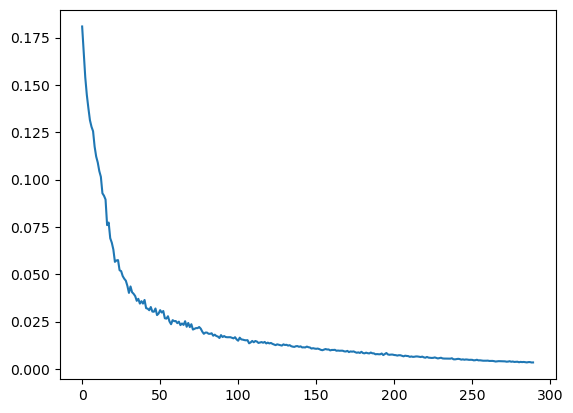

In [11]:
from modular_rnn.training import train

losses = train(rnn, task, 300, loss_fn)
plt.plot(losses[10:]);

# Test the model's behavior on some test trials

Run a few batches of test trials

In [12]:
from modular_rnn.testing import run_test_batches

test_df = run_test_batches(10, rnn, task)

Produced "hand" trajectories

In [13]:
from pysubspaces.plotting import get_color_cycle

Text(0, 0.5, 'y')

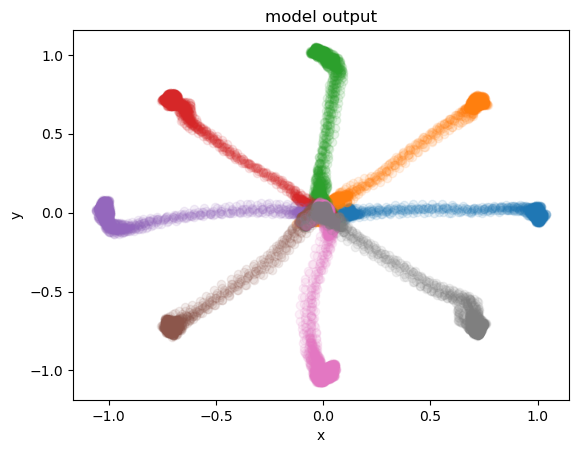

In [14]:
fig, ax = plt.subplots()

for (tid, target_df) in test_df.groupby('target_id'):
    for arr in target_df.hand_model_output.values[:10]:
        ax.scatter(*arr.T, alpha = 0.1, color = get_color_cycle()[tid])
        
ax.set_title('model output')
ax.set_xlabel('x')
ax.set_ylabel('y')